In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import os
os.makedirs("../out", exist_ok=True)

from tqdm import tqdm

# Q2: Affine Motion Subtraction

Make sure to comment your code and use proper names for your variables.

## Q2.1: Lucas-Kanade Tracking with Affine Motion

In [10]:
# We recommend using this function, but you can explore other methods as well (e.g., ndimage.shift).
from scipy.interpolate import RectBivariateSpline

# The function below could be useful as well :) 
from numpy.linalg import lstsq

def LucasKanadeAffine(It, It1, threshold, num_iters):
    """
    :param[np.array(H, W)] It   : Image frame at time-step t
    :param[np.array(H, W)] It1  : Image frame at time-step t+1
    :param[float] threshold     : If the length of dp < threshold, terminate the optimization
    :param[int] num_iters       : Number of iterations for running the optimization

    :return[np.array(2, 3)] M   : Affine warp matrix
    """
    # Initial M
    # M = np.eye(3)
    M = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]])
    
    # ----------------------------------------------------------------------------------------------
    # TODO: Add your LK implementation here: 

    # Use whole img to build mode:
    y=np.arange(0,It1.shape[0])
    x=np.arange(0,It1.shape[1])

    # build mode for interpolation of It, It1
    mode1 = RectBivariateSpline(y, x, It1)
    mode_tmp=RectBivariateSpline(y, x, It)

    # model for gradient
    gIy,gIx=np.gradient(It1)
    mode_gx = RectBivariateSpline(y, x, gIx)
    mode_gy=  RectBivariateSpline(y, x, gIy)

    # for iteration times
    times = 0

    delta_threshold=2
    xv,yv=np.meshgrid(x,y)
    
    while ( delta_threshold>= threshold) and (times<num_iters):
        # 1.Warp I with W(x;p), I(W(x;p);
        # get new w and h
        M_x = M[0]
        M_y = M[1]
        new_x = M_x[0] * xv + M_x[1] * yv+M_x[2]
        new_y = M_y[0] * xv + M_y[1] * yv+M_y[2]

        #computed only on the pixels lying in the region common to It and the warped version of It+1.
        # build matrix -> range
        x_region = np.logical_and(new_x>0,new_x<It.shape[1])
        y_region = np.logical_and(new_y>0,new_y<It.shape[0])
        in_region = np.logical_and(x_region,y_region)
        # delte pixels not in range
        new_x = new_x[in_region]
        new_y = new_y[in_region]
        new_xv=xv[in_region]
        new_yv=yv[in_region]
        
        # 2.Compute error image T(x) - I(W(x;p))
        # get new img
        new_I=mode1(new_y,new_x,grid=False)
        #print(new_I.shape)
        b_new_I = new_I.reshape(-1,1)
        # to match dimension, also delte tmplate not in range
        b_tmp=It[in_region]
        #print(b_new_I.shape,b_tmp.shape)
        b_tmp=b_tmp.reshape(-1,1)
        b=b_tmp-b_new_I

        # 3.Warp gradient image I with W(x;p) -> according to writeup, need to use 2nd method 
        # method1 -> not use
        # gradient_x=mode1(new_y, new_x, dy=1,grid=False)
        # gradient_y=mode1(new_y, new_x, dx=1,grid=False) 
        # method 2
        gradient_x=mode_gx(new_y,new_x,grid=False)
        gradient_y=mode_gy(new_y,new_x,grid=False)

        gradient_x=gradient_x.reshape(1,-1)[0]
        gradient_y=gradient_y.reshape(1,-1)[0]

        # 4.Evaluate Jacobian
        # looks like this:
        # [x y 1 0 0 0]
        # [0 0 0 x y 1]
        A=[]
        A1=[]
        A2=[]
        A3=[]
        A4=[]
        new_xv=new_xv.reshape(1,-1)[0]
        new_yv=new_yv.reshape(1,-1)[0]
    
        #5. Compute the steepest descent img
        for i in range(len(gradient_x)):
            A1.append(gradient_x[i]*new_xv[i])
            A2.append(gradient_y[i]*new_xv[i])
            A3.append(gradient_x[i]*new_yv[i])
            A4.append(gradient_y[i]*new_yv[i])
        A.append(A1)
        A.append(A3)
        A.append(gradient_x.tolist())
        A.append(A2)
        A.append(A4)
        A.append(gradient_y.tolist())
        A=np.array(A)
        # transpose
        A=np.transpose(A,(1,0))
        # 6.Compute delta p
        delta_p=np.linalg.lstsq(A, b, rcond=None)[0]
        # 7.Update parameters p ← p + delta p
        delta_threshold=np.linalg.norm(delta_p)
        # print(delta_p.shape)
        M[0][0]+=delta_p[0]
        M[0][1]+=delta_p[1]
        M[0][2]+=delta_p[2]
        M[1][0]+=delta_p[3]
        M[1][1]+=delta_p[4]
        M[1][2]+=delta_p[5]
    #print(M)
    # ----------------------------------------------------------------------------------------------
    return M

# Q2.2: Dominant Motion Subtraction

In [11]:
# These functions could be useful for your implementation. 
from scipy.ndimage import binary_erosion, binary_dilation, affine_transform
import cv2

def SubtractDominantMotion(It, It1, num_iters, threshold, tolerance):
    """
    :param[np.array(H, W)] It   : Image frame at time-step t
    :param[np.array(H, W)] It1  : Image frame at time-step t+1
    :param[float] threshold     : For LucasKanadeAffine --> If the length of dp < threshold, 
                                  terminate the optimization
    :param[int] num_iters       : For LucasKanadeAffine --> Number of iterations for running the 
                                  optimization
    :param[float] tolerance     : Binary threshold of intensity difference when computing the mask.
   
    :return[np.array(H, W)] mask: Binary mask indicating moving pixels. 
    """
    mask = np.ones(It1.shape, dtype=bool)

    # ----------------------------------------------------------------------------------------------
    # TODO: Add your code here:
    m=LucasKanadeAffine(It,It1,threshold,num_iters)

    #computed only on the pixels lying in the region common to It and the warped version of It+1.
    m_x = m[0]
    m_y = m[1]
    y=np.arange(0,It1.shape[0])
    x=np.arange(0,It1.shape[1])
    xv,yv=np.meshgrid(x,y)
    new_x = m_x[0] * xv + m_x[1] * yv+m_x[2]
    new_y = m_y[0] * xv + m_y[1] * yv+m_y[2]
    # in region matrix
    x_region = np.logical_and(new_x>0,new_x<It.shape[1])
    y_region = np.logical_and(new_y>0,new_y<It.shape[0])
    in_region = np.logical_and(x_region,y_region)

    # Warp the image It using M, register to It+1
    #m_inv = np.linalg.inv(m)
    #It_warp = affine_transform(It,m_inv)
    h=It.shape[0]
    w=It.shape[1]
    It_warp= cv2.warpAffine(It,m,(w,h))

    # Subtract the warped image from It+1
    It_diff = np.abs(It_warp-It1)
    # mask function to get 0 or 1
    # if > tolerance: True
    def mask(x,tol):
        if x < tol:
            return False
        else:
            return True
    func = np.vectorize(mask)
    mask = func(It_diff,tolerance)

    # these not in region: false
    mask[~in_region] = False

    # make it looks better
    kernel_e = np.ones((3,3))
    kernel_d = np.ones((4,4))
    #mask=binary_erosion(mask,kernel_e)#,iterations=1)
    mask=binary_dilation(mask,kernel_d,iterations=2)
    mask=binary_erosion(mask,kernel_e,iterations=2)
    
    # print(mask)


    # ----------------------------------------------------------------------------------------------
    return mask 

(-0.5, 255.5, 255.5, -0.5)

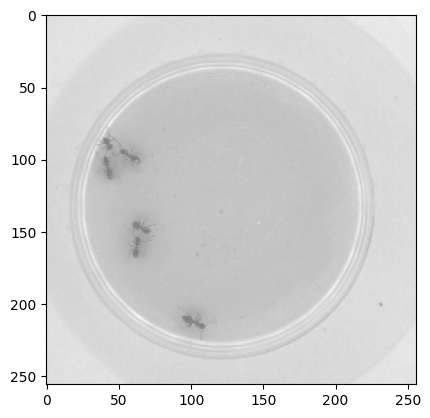

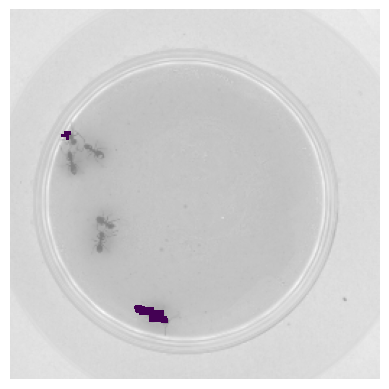

In [12]:
# test for one
seq = np.load("../data/antseq.npy")
plt.imshow(seq[:,:,30], cmap="gray", alpha=0.5)
mask=SubtractDominantMotion(seq[:,:,29],seq[:,:,30],1000,0.01,0.2)
plt.figure()
plt.imshow(seq[:,:,30], cmap="gray", alpha=0.5)
plt.imshow(np.ma.masked_where(np.invert(mask), mask))
plt.axis('off')
#plt.savefig(f"../out/sol_2.3_antseq_{idx+1}.png")

## Q2.3: Track Sequence

In [13]:
def TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance):
    """
    :param[np.array(H, W, N)] seq : sequence of frames
    :param[int] num_iters         : Number of iterations for running the optimization
    :param[float] threshold       : If the length of dp < threshold, terminate the optimization
    :param[float] tolerance       : Binary threshold of intensity difference when computing the mask.

    :return[np.array(H, W)] mask: Binary mask indicating moving pixels.
    """
    H, W, N = seq.shape

    masks = []
    It = seq[:,:,0]

    # ----------------------------------------------------------------------------------------------
    # TODO: Add your code here:
    for i in tqdm(range(1, seq.shape[2])):
        mask = SubtractDominantMotion(seq[:,:,i-1],seq[:,:,i],num_iters,threshold,tolerance)
        masks.append(mask)

    # ----------------------------------------------------------------------------------------------
    masks = np.stack(masks, axis=2)
    return masks

### Q2.3: Track Ant Sequence

Feel free to play with these snippets of code; run ablations, visualize a gif with the whole sequence, etc.

Just make sure the bounding boxes for the car are clearly visible, and report those of the frames we requested. 

In [14]:
seq = np.load("../data/antseq.npy")

# NOTE: feel free to play with these parameters
num_iters = 1e4
threshold = 1e-2
tolerance = 0.2
masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
np.save(f'../out/antseqmasks.npy', masks)

100%|██████████| 124/124 [01:52<00:00,  1.10it/s]


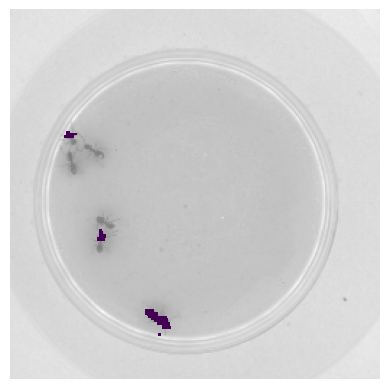

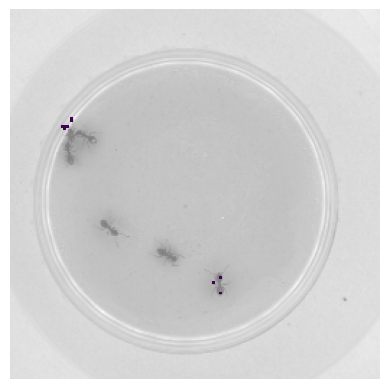

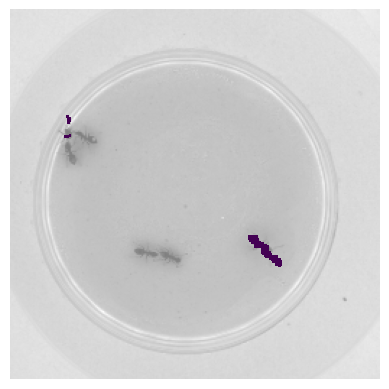

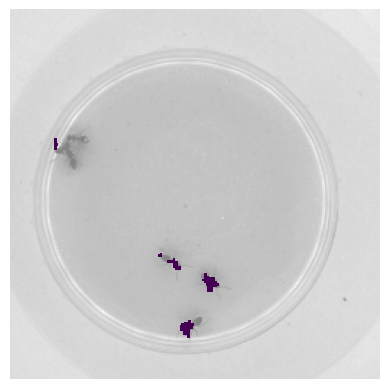

In [15]:
# TODO: visualize
frames_to_save = [30, 60, 90, 120]
seq= np.load("../data/antseq.npy")
masks=np.load("../out/antseqmasks.npy")

for idx in frames_to_save:
    #pass
    frame = seq[:,:,idx]
    mask = masks[:,:,idx]
   
    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask))
    plt.axis('off')
    plt.savefig(f"../out/sol_2.3_antseq_{idx+1}.png")

### Q2.3: Test Aerial Sequence

Feel free to play with these snippets of code; run ablations, visualize a gif with the whole sequence, etc.

Just make sure the bounding boxes for the car are clearly visible, and report those of the frames we requested. 

In [16]:
seq = np.load("../data/aerialseq.npy")

# NOTE: feel free to play with these parameters
num_iters = 1000
threshold = 0.01
tolerance = 0.2

masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
np.save(f'../out/aerialseqmasks.npy', masks)

100%|██████████| 149/149 [05:06<00:00,  2.06s/it]


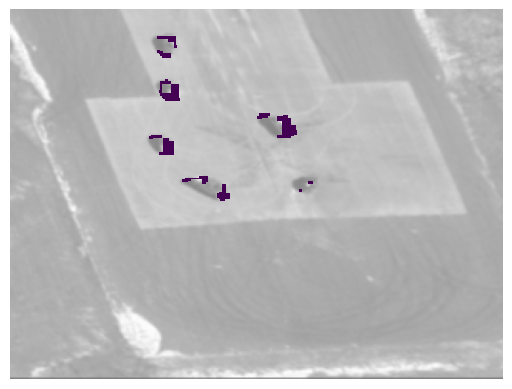

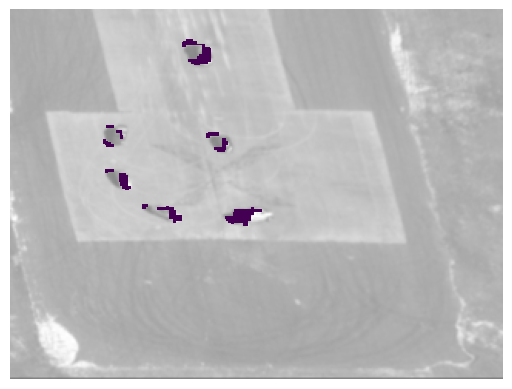

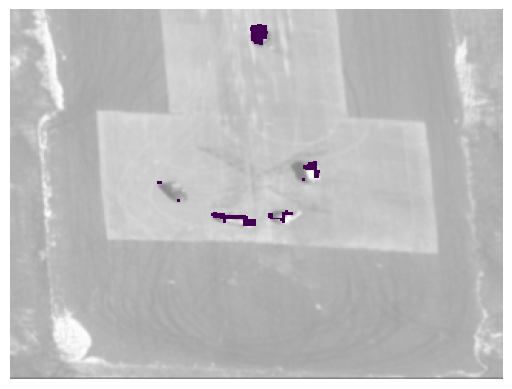

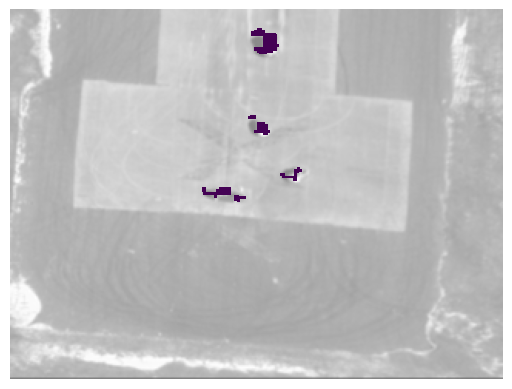

In [17]:
# TODO: visualize
frames_to_save = [30, 60, 90, 120]
seq= np.load("../data/aerialseq.npy")
masks=np.load("../out/aerialseqmasks.npy")

for idx in frames_to_save:
    #pass
    frame = seq[:,:,idx]
    mask = masks[:,:,idx]
   
    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask))
    plt.axis('off')
    plt.savefig(f"../out/sol_2.3_aerialseq_{idx+1}.png")